# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 1:04:16
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 24 Aug 2023 06:55:47 AM PDT
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0x0
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor

# Helper functions

In [6]:
def enableAllAsics(enable) :
    BATCHER0.Blowoff.set(not enable)
    BATCHER1.Blowoff.set(not enable)
    BATCHER2.Blowoff.set(not enable)
    BATCHER3.Blowoff.set(not enable)
    
def enableAsic(batcherIndex, enable) :
    getattr(root.App.AsicTop, f"BatcherEventBuilder{batcherIndex}").Blowoff.set(not enable)    
    
# Helper functions

def disableAndCleanAllFullRateDataRcv() :
    FULLRATERCV0.cleanData()
    FULLRATERCV1.cleanData()
    FULLRATERCV2.cleanData()
    FULLRATERCV3.cleanData()
    FULLRATERCV0.RxEnable.set(False)
    FULLRATERCV1.RxEnable.set(False)
    FULLRATERCV2.RxEnable.set(False)
    FULLRATERCV3.RxEnable.set(False)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)
    
    
def enableDataRcv(enable) :
    DATARCV0.RxEnable.set(enable)
    DATARCV1.RxEnable.set(enable)
    DATARCV2.RxEnable.set(enable)
    DATARCV3.RxEnable.set(enable)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)    

In [7]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [8]:
def hwTrigger(frames, rate) :
    # precaution in case someone stops the acquire function in the middle
    TRIG.StopTriggers() 
    
    TRIG.AcqCountReset()
    TRIG.SetAutoTrigger(rate)
    TRIG.numberTrigger.set(frames)
    TRIG.StartAutoTrigger()
    
    # Wait for the file write to write the 10 waveforms
    while (TRIG.AcqCount.get() != frames) :
        print("Triggers sent: {}".format(TRIG.AcqCount.get()) , end='\r')
        time.sleep(0.1)
    print("Triggers sent: {}".format(TRIG.AcqCount.get()))
    
    # stops triggers
    TRIG.StopTriggers()  

In [9]:
def getLaneLocks() :
    for asicIndex in range(4) : 
        root.App.SspMonGrp[asicIndex].enable.set(True)
        print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

In [10]:
#check current frames in receivers
def printDataReceiverStatus() :
    for asicIndex in range(4):
        print("Checkpoint: DataReceiver {} has {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

# Disable full rate receivers for now

In [11]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableAllAsics(False)
root.enableAsic(3, True)
DEBUG3.enableDataDebug(True)
DEBUG3.cleanData()

# Lorenzo - Helper functions

In [12]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# ADC Response with external DAC single writes

In [13]:
ASIC3.DHg.set(True)    # Set High gain
ASIC3.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC3.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC3.RefGenB.set(2)   # Don't touch

# Define integration time
setR0(420, 200)
setAcq1(160, 360)

baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'-------------------------')


R0 Width set to 2.688uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 2.304uS
Baseline time:    1.0239999999999998 uS
Integration time: 1.024 uS
-------------------------


# Fixed High gain = set CompTH to minimum

Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Des

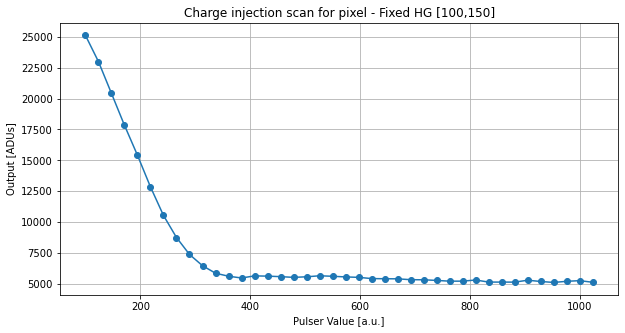

In [15]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
ASIC3.Precharge_DAC_ePixM.set(40)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(4)
ASIC3.RefinP.set(4)


# Get ramps and calculate gain
ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=100,Max=1023,numSteps=40)



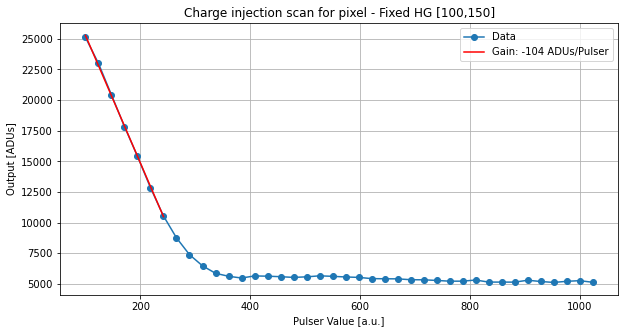

In [30]:
plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")

# Fit
fit_indices = (ChInjValues <= 250)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='red', label='Gain: {:.1f} ADUs/Pulser'.format(gain))

plt.title('Charge injection scan for pixel - Fixed HG [{},{}]'.format(ref_row,ref_col))
plt.legend()
plt.grid(True)

# Fixed low-gain: set CompTH to maximum (min energy)

In [68]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(63)
ASIC3.Precharge_DAC_ePixM.set(50)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(4)
ASIC3.RefinP.set(4)


# Get ramps and calculate gain
ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=100,Max=1023,numSteps=20)

Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)


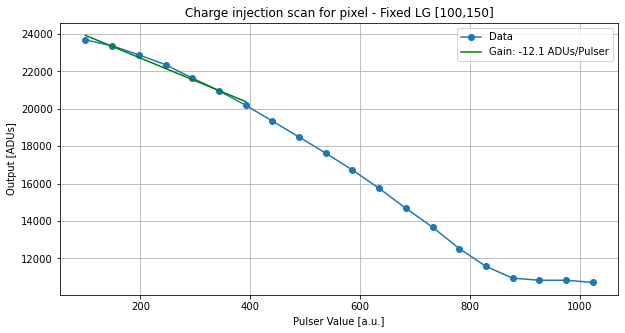

In [69]:
PixOutValues = clearB16(PixOutValues.astype(int))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")


# Fit
fit_indices = (ChInjValues <= 400)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain: {:.1f} ADUs/Pulser'.format(gain))

plt.title('Charge injection scan for pixel - Fixed LG [{},{}]'.format(ref_row,ref_col))
plt.legend()
plt.grid(True)

# Auto-gain switching: tune CompTH and Vprech

Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Des

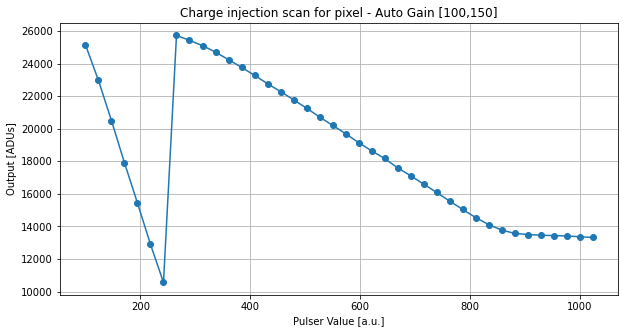

In [57]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(10)
ASIC3.Precharge_DAC_ePixM.set(40)

# Reference pixel
ref_row = 100
ref_col = 150

ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=100,Max=1023,numSteps=40)

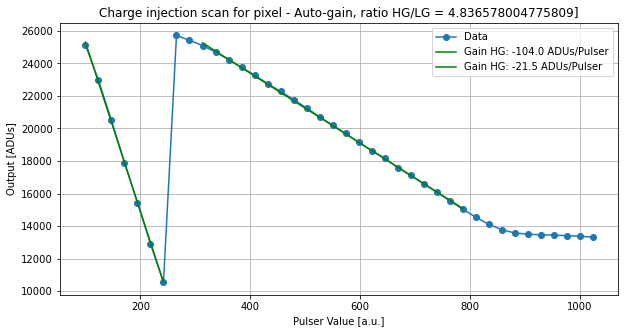

In [63]:
PixOutValues = clearB16(PixOutValues.astype(int))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")


# Fit HG
fit_indices = (ChInjValues <= 250)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain HG: {:.1f} ADUs/Pulser'.format(gain))
gain_hg = gain

# Fit LG
fit_indices = (ChInjValues <= 800) & (ChInjValues > 300)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
gain, offset = np.polyfit(ChInjValues_fit, PixOutValues_fit, 1)
polyfit_function = np.poly1d([gain, offset])
plt.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='green', label='Gain HG: {:.1f} ADUs/Pulser'.format(gain))
gain_lg = gain


plt.title('Charge injection scan for pixel - Auto-gain, ratio HG/LG = {}]'.format(gain_hg/gain_lg))
plt.legend()
plt.grid(True)